# Projeto Final - Limpeza de Dados

## Setup

In [2]:
from pyspark.sql import functions as sf

In [3]:
# Criar a sessao do Spark
from pyspark.sql import SparkSession
spark = SparkSession \
            .builder \
            .master("local[4]") \
            .appName("nyc_caio_garcia") \
            .config("spark.jars.packages", "org.apache.hadoop:hadoop-azure:3.3.4,com.microsoft.azure:azure-storage:8.6.6") \
            .getOrCreate()

In [5]:
# Acesso aos dados na nuvem
STORAGE_ACCOUNT = 'dlspadseastusprod'
CONTAINER = 'big-data-comp-nuvem'
FOLDER = 'airline-delay'
TOKEN = 'lSuH4ZI9BhOFEhCF/7ZQbrpPBIhgtLcPDfXjJ8lMxQZjaADW4p6tcmiZGDX9u05o7FqSE2t9d2RD+ASt0YFG8g=='

spark.conf.set("fs.azure.account.key." + STORAGE_ACCOUNT + ".blob.core.windows.net", TOKEN)

In [6]:
## Bibliotecas Gráficas
import seaborn as sns
import matplotlib.pyplot as plt

### Schema
Schema definido de acordo com o dicionário de dados em `projeto_final_dicionário.xlsx`

In [7]:
from pyspark.sql.types import *

labels = (('FL_DATE', TimestampType()),
          ('OP_CARRRIER', StringType()),
          ('OP_CARRIER_FL_NUM', IntegerType()),
          ('ORIGIN', StringType()),
          ('DEST', StringType()),
          ('CRS_DEP_TIME', IntegerType()),
          ('DEP_TIME', FloatType()),
          ('DEP_DELAY', FloatType()),
          ('TAXI_OUT', FloatType()),
          ('WHEELS_OFF', FloatType()),
          ('WHEELS_ON', FloatType()),
          ('TAXI_IN', FloatType()),
          ('CRS_ARR_TIME', IntegerType()),
          ('ARR_TIME', FloatType()),
          ('ARR_DELAY', FloatType()),
          ('CANCELLED', FloatType()),
          ('CANCELLATION_CODE', StringType()),
          ('DIVERTED', FloatType()),
          ('CRS_ELAPSED_TIME', FloatType()),
          ('ACTUAL_ELAPSED_TIME', FloatType()),
          ('AIR_TIME', FloatType()),
          ('DISTANCE', FloatType()),
          ('CARRIER_DELAY', FloatType()),
          ('WEATHER_DELAY', FloatType()),
          ('NAS_DELAY', FloatType()),
          ('SECURITY_DELAY', FloatType()),
          ('LATE_AIRCRAFT_DELAY', StringType()))

schema = StructType([StructField(x[0], x[1], True) for x in labels])

### Carregamento de dados
Dados carregados da nuvem como spark data frame

Exemplo para o ano de 2009:

In [8]:
config = spark.sparkContext._jsc.hadoopConfiguration()
config.set("fs.azure.account.key." + STORAGE_ACCOUNT + ".blob.core.windows.net", TOKEN)
sc = spark.sparkContext

df_exemple = spark.read.csv("wasbs://{}@{}.blob.core.windows.net/{}/2009.csv"\
                    .format(CONTAINER, STORAGE_ACCOUNT, FOLDER), header=True, schema=schema)
df_exemple.take(2)

[Row(FL_DATE=datetime.datetime(2009, 1, 1, 0, 0), OP_CARRRIER='XE', OP_CARRIER_FL_NUM=1204, ORIGIN='DCA', DEST='EWR', CRS_DEP_TIME=1100, DEP_TIME=1058.0, DEP_DELAY=-2.0, TAXI_OUT=18.0, WHEELS_OFF=1116.0, WHEELS_ON=1158.0, TAXI_IN=8.0, CRS_ARR_TIME=1202, ARR_TIME=1206.0, ARR_DELAY=4.0, CANCELLED=0.0, CANCELLATION_CODE=None, DIVERTED=0.0, CRS_ELAPSED_TIME=62.0, ACTUAL_ELAPSED_TIME=68.0, AIR_TIME=42.0, DISTANCE=199.0, CARRIER_DELAY=None, WEATHER_DELAY=None, NAS_DELAY=None, SECURITY_DELAY=None, LATE_AIRCRAFT_DELAY=None),
 Row(FL_DATE=datetime.datetime(2009, 1, 1, 0, 0), OP_CARRRIER='XE', OP_CARRIER_FL_NUM=1206, ORIGIN='EWR', DEST='IAD', CRS_DEP_TIME=1510, DEP_TIME=1509.0, DEP_DELAY=-1.0, TAXI_OUT=28.0, WHEELS_OFF=1537.0, WHEELS_ON=1620.0, TAXI_IN=4.0, CRS_ARR_TIME=1632, ARR_TIME=1624.0, ARR_DELAY=-8.0, CANCELLED=0.0, CANCELLATION_CODE=None, DIVERTED=0.0, CRS_ELAPSED_TIME=82.0, ACTUAL_ELAPSED_TIME=75.0, AIR_TIME=43.0, DISTANCE=213.0, CARRIER_DELAY=None, WEATHER_DELAY=None, NAS_DELAY=None, S

Como temos dados para os anos de 2009 até o ano de 2018. Iremos criar um dicionario contendo os dataframes de cada ano separadamente. 

In [9]:
# Criando dicionario de dataframes
df_for_year = {}

# Loop lendo arquivo de cada ano e salvando no dicionario
for year in range(2009, 2019):
    # Ajustando o caminho
    file_path = "wasbs://{}@{}.blob.core.windows.net/{}/{}.csv"\
                    .format(CONTAINER, STORAGE_ACCOUNT, FOLDER, year)
    
    # lendo arquivo csv 
    df_name = "df_{}".format(year)
    df = spark.read.csv(file_path, header=True, schema=schema)
    
    # Adicionando df ao dicionario de dataframes 
    df_for_year[df_name] = df
    

# Visualizando as primeiras linhas de 2012
df_for_year["df_2012"].take(5)

[Row(FL_DATE=datetime.datetime(2012, 1, 1, 0, 0), OP_CARRRIER='MQ', OP_CARRIER_FL_NUM=4041, ORIGIN='BMI', DEST='ORD', CRS_DEP_TIME=None, DEP_TIME=1702.0, DEP_DELAY=-13.0, TAXI_OUT=9.0, WHEELS_OFF=1711.0, WHEELS_ON=1748.0, TAXI_IN=9.0, CRS_ARR_TIME=None, ARR_TIME=1757.0, ARR_DELAY=-13.0, CANCELLED=0.0, CANCELLATION_CODE=None, DIVERTED=0.0, CRS_ELAPSED_TIME=55.0, ACTUAL_ELAPSED_TIME=55.0, AIR_TIME=37.0, DISTANCE=116.0, CARRIER_DELAY=None, WEATHER_DELAY=None, NAS_DELAY=None, SECURITY_DELAY=None, LATE_AIRCRAFT_DELAY=None),
 Row(FL_DATE=datetime.datetime(2012, 1, 1, 0, 0), OP_CARRRIER='MQ', OP_CARRIER_FL_NUM=4041, ORIGIN='ORD', DEST='BMI', CRS_DEP_TIME=None, DEP_TIME=1540.0, DEP_DELAY=-5.0, TAXI_OUT=11.0, WHEELS_OFF=1551.0, WHEELS_ON=1614.0, TAXI_IN=5.0, CRS_ARR_TIME=None, ARR_TIME=1619.0, ARR_DELAY=-16.0, CANCELLED=0.0, CANCELLATION_CODE=None, DIVERTED=0.0, CRS_ELAPSED_TIME=50.0, ACTUAL_ELAPSED_TIME=39.0, AIR_TIME=23.0, DISTANCE=116.0, CARRIER_DELAY=None, WEATHER_DELAY=None, NAS_DELAY=None

Com todos os dataframes pré-importados(lazy) podemos realizar um merge unindo todos os anos.

In [10]:
# Importando função reduce para realizar o merge
from functools import reduce 

In [11]:
# União de todos os DataFrames em um único Data frame
df_final = reduce(sf.DataFrame.union, df_for_year.values())

# Criando a coluna "year" baseada na coluna "date"
df_final = df_final.withColumn("year", sf.year("FL_DATE"))

# Exibindo as primeiras linhas
df_final.take(10)

[Row(FL_DATE=datetime.datetime(2009, 1, 1, 0, 0), OP_CARRRIER='XE', OP_CARRIER_FL_NUM=1204, ORIGIN='DCA', DEST='EWR', CRS_DEP_TIME=1100, DEP_TIME=1058.0, DEP_DELAY=-2.0, TAXI_OUT=18.0, WHEELS_OFF=1116.0, WHEELS_ON=1158.0, TAXI_IN=8.0, CRS_ARR_TIME=1202, ARR_TIME=1206.0, ARR_DELAY=4.0, CANCELLED=0.0, CANCELLATION_CODE=None, DIVERTED=0.0, CRS_ELAPSED_TIME=62.0, ACTUAL_ELAPSED_TIME=68.0, AIR_TIME=42.0, DISTANCE=199.0, CARRIER_DELAY=None, WEATHER_DELAY=None, NAS_DELAY=None, SECURITY_DELAY=None, LATE_AIRCRAFT_DELAY=None, year=2009),
 Row(FL_DATE=datetime.datetime(2009, 1, 1, 0, 0), OP_CARRRIER='XE', OP_CARRIER_FL_NUM=1206, ORIGIN='EWR', DEST='IAD', CRS_DEP_TIME=1510, DEP_TIME=1509.0, DEP_DELAY=-1.0, TAXI_OUT=28.0, WHEELS_OFF=1537.0, WHEELS_ON=1620.0, TAXI_IN=4.0, CRS_ARR_TIME=1632, ARR_TIME=1624.0, ARR_DELAY=-8.0, CANCELLED=0.0, CANCELLATION_CODE=None, DIVERTED=0.0, CRS_ELAPSED_TIME=82.0, ACTUAL_ELAPSED_TIME=75.0, AIR_TIME=43.0, DISTANCE=213.0, CARRIER_DELAY=None, WEATHER_DELAY=None, NAS_DE

Assim, temos o dataframe com todos os anos.

In [12]:
OBSERVACOES = df_final.count()
assert (OBSERVACOES == 61556964)

In [13]:
OBSERVACOES

61556964

A base contem 61556964 observações.

In [14]:
CANCELAMENTOS = df_final.filter(df_final.CANCELLED == 1).count()
assert (CANCELAMENTOS == 973209)

In [15]:
CANCELAMENTOS

973209

Dos voos na base, 973209 foram cancelados.

## Tratamento de dados faltantes

Das 27 colunas na base de dados, 16 tem valores faltantes. Os dados ausentes na coluna CANCELATION_CODE sao 100% consistentes com a informacao de cancelamento, isto eh, apenas os voos que nao foram cancelados tem a coluna CANCELATION_CODE vazia. As outras 15 colunas podem ser agrupadas em 3 grupos: _Voo_, _Chegada_ e _Atrasos_.

### Resumo

In [16]:
missing_counts = df_final.select([sf.col(column).isNull().cast("int").alias(column) for column in df_final.columns]) \
                       .groupBy() \
                       .sum()

In [17]:
# Criando dataframe de colunas com valores zerados
missing_counts_df = missing_counts.toPandas().transpose()

# Filtrando apenas colunas com valores nulos
missing_counts_df = missing_counts_df[missing_counts_df[0]>0]

# Renomeando a coluna
missing_counts_df = missing_counts_df.rename(columns={0:"nulos"})

In [18]:
# Contando número de colunas com valores nulos
print("Número de colunas com valores faltantes:")
missing_counts_df.count()[0]

Número de colunas com valores faltantes:


19

In [19]:
# Cálculando porcentagem de valores faltantes
missing_counts_df["%nulos"] = (missing_counts_df["nulos"]/OBSERVACOES) * 100

# Ordenando por % de nulos
missing_counts_df = missing_counts_df.sort_values("%nulos", ascending=False)

# Visualizando resultados
missing_counts_df

,nulos,%nulos
sum(CANCELLATION_CODE),60583755,98.419011
sum(LATE_AIRCRAFT_DELAY),50166224,81.495611
sum(SECURITY_DELAY),50166224,81.495611
sum(NAS_DELAY),50166224,81.495611
sum(WEATHER_DELAY),50166224,81.495611
sum(CARRIER_DELAY),50166224,81.495611
sum(CRS_ARR_TIME),6096762,9.904260
sum(CRS_DEP_TIME),6096762,9.904260
sum(ARR_DELAY),1121351,1.821648
sum(ACTUAL_ELAPSED_TIME),1118754,1.817429


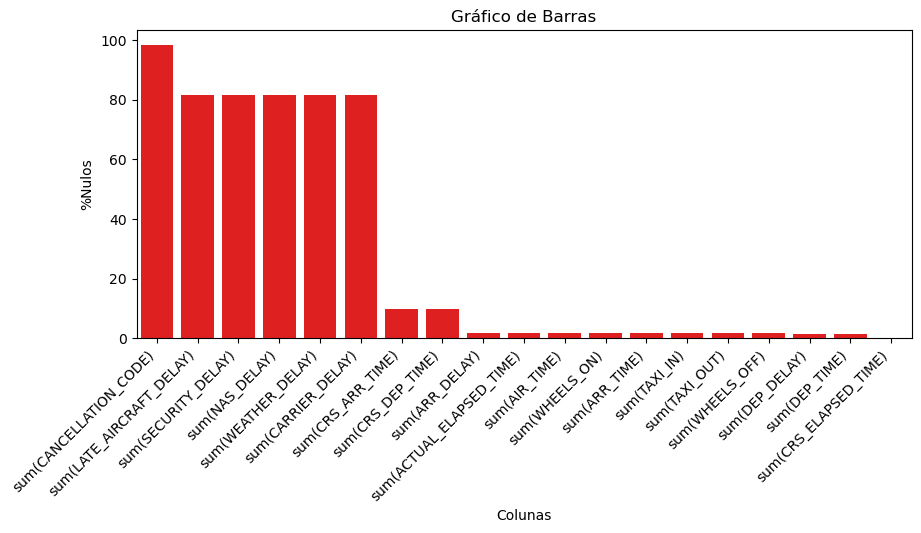

In [20]:
# Visualizando missing em gráfico de barras
# Ajustando o tamanho da figura
plt.figure(figsize=(10, 4))

# Plotando o gráfico de barras
sns.barplot(x=missing_counts_df.index, y=missing_counts_df["%nulos"], color="red")

# Adicionando inclinação aos valores do eixo x
plt.xticks(rotation=45, ha='right')

# Adicionando título e rótulos aos eixos
plt.title('Gráfico de Barras')
plt.xlabel("Colunas")
plt.ylabel("%Nulos")

# Exibindo o gráfico
plt.show()

Conforme evidenciado no gráfico apresentado, nota-se que a coluna "CANCELLATION_CODE" exibe uma lacuna em praticamente 100% dos dados, enquanto as colunas "LATE_AIRCRAFT_DELAY", "NAS_DELAY", "WEATHER_DELAY", "CARRIER_DELAY" e "SECURITY_DELAY" apresentam uma ausência de informações em torno de 80%.

### Cancelamentos

In [66]:
assert (df_final.filter((df_final.CANCELLATION_CODE.isNull()) &
                  (df_final.CANCELLED == 0)).count() ==
        df_final.filter(df_final.CANCELLED == 0).count())

Todos os valores faltantes de CANCELLATION_CODE são referentes a voos que não foram cancelados.

### Voo

#### Testes

In [ ]:
assert (df_final.filter((df_final.DEP_TIME.isNull())   &
                  (df_final.DEP_DELAY.isNull())  &
                  (df_final.TAXI_OUT.isNull())   &
                  (df_final.WHEELS_OFF.isNull()) &
                  (df_final.WHEELS_ON.isNull())  &
                  (df_final.TAXI_IN.isNull())    &
                  (df_final.ARR_TIME.isNull())).count() ==
        df_final.filter(df_final.DEP_TIME.isNull()).count())

assert (df_final.filter((df_final.DEP_TIME.isNull())   &
                  (df_final.DEP_DELAY.isNull())).count() ==
        df_final.filter(df_final.DEP_TIME.isNull()).count())

In [ ]:
assert (df_final.filter((df_final.DEP_TIME.isNull())   &
                  (df_final.CANCELLED == 1)).count() ==
        df_final.filter(df_final.DEP_TIME.isNull()).count())

In [ ]:
assert (df_final.filter((df_final.TAXI_OUT.isNull())   &
                  (df_final.WHEELS_OFF.isNull()) &
                  (df_final.WHEELS_ON.isNull())  &
                  (df_final.TAXI_IN.isNull())    &
                  (df_final.ARR_TIME.isNull())).count() ==
        df_final.filter(df_final.TAXI_OUT.isNull()).count())

assert (df_final.filter((df_final.TAXI_OUT.isNull())   &
                  (df_final.WHEELS_OFF.isNull())).count() ==
        df_final.filter(df_final.TAXI_OUT.isNull()).count())

In [ ]:
assert (df_final.filter((df_final.TAXI_OUT.isNull())   &
                  (df_final.CANCELLED == 1)).count() ==
       df_final.filter(df_final.TAXI_OUT.isNull()).count())

In [ ]:
assert (df_final.filter((df_final.WHEELS_ON.isNull())  &
                  (df_final.TAXI_IN.isNull())    &
                  (df_final.ARR_TIME.isNull())).count() ==
        df_final.filter(df_final.TAXI_IN.isNull()).count())

In [ ]:
assert (df_final.filter((df_final.TAXI_IN.isNull())   &
                  (df_final.CANCELLED == 1)).count() ==
        df_final.filter(df_final.CANCELLED == 1).count())

#### Análise

O grupo _Voo_ apresenta uma relação entre voos cancelados e as 7 variáveis:
 - DEP_TIME
 - DEP_DELAY
 - TAXI_OUT
 - WHEELS_OFF
 - WHEELS_ON
 - TAXI_IN
 - ARR_TIME
 
Os valores faltantes para WHEELS_ON, TAXI_IN e ARR_TIME coincidem nas mesmas observações (com uma exceção descrita mais abaixo). Todos os voos cancelados se encontram dentre essas observações. Os valores faltantes para TAXI_OUT e WHEELS_OFF coincidem nas mesmas observações, todas referentes a voos cancelados. Finalmente, os valores faltantes de DEP_TIME e DEP_DELAY coincidem nas mesmas observações, todas com valores faltantes para TAXI_OUT.

Destas relações, supomos:
 - Alguns voos parecem não ter sua chegada propriamente registrada. Casos de pousos de emergencia em localização diferente da planejada são plausíveis mas supomos que sejam menos frequentes. Esses casos (`(df.WHEELS_ON.isNull()) & (df.CANCELLED == 0)`) podem vir a ser uma categoria relevante na análise.
 - A diferença entre DEP_TIME e WHEELS_OFF pode ser devido a voos que chegam a sair do chão antes de serem cancelados, e voos que são cancelados após o embarque mas antes da decolagem.
 - Nenhum desses valores faltantes parece implausível o suficiente para assumirmos erro nos dados baseado apenas nessa análise. Alguns desses dados podem vir a ser retirados mesmo assim por questão de propriedades dos algorítmos utilizados mais a frente.

### Chegada

### Atrasos
TODO

#### Testes

In [ ]:
assert (df.filter((df.CANCELLED == 0) &
                  (df.DEP_DELAY > 0)).count() == 
        2252608)

In [ ]:
assert (df.filter((df.CANCELLED == 0) &
                  (df.ARR_DELAY > 0)).count() ==
        2402990)

In [ ]:
assert (df.filter((df.CANCELLED == 0) &
                  ((df.DEP_DELAY > 0) |
                   (df.ARR_DELAY > 0))).count() ==
        3052688)

In [ ]:
assert (OBSERVACOES - df.filter(df.CARRIER_DELAY.isNull()).count() ==
        1170501)

In [ ]:
assert (df.filter((df.CARRIER_DELAY.isNull()) &
                  (df.WEATHER_DELAY.isNull()) &
                  (df.NAS_DELAY.isNull()) &
                  (df.SECURITY_DELAY.isNull()) &
                  (df.LATE_AIRCRAFT_DELAY.isNull())).count() ==
        df.filter(df.CARRIER_DELAY.isNull()).count())

In [ ]:
assert (df.filter((df.CARRIER_DELAY.isNull()) &
                  ((df.DEP_DELAY > 0) |
                   (df.ARR_DELAY > 0))).count() ==
        df.filter(df.CARRIER_DELAY.isNull()).count())

In [ ]:
df.filter(df.CARRIER_DELAY == 0).select(df.OP_CARRIER_FL_NUM, df.CARRIER_DELAY).take(10)

#### Análise

Todos os dados faltantes referentes a categoria de atraso coincidem nas mesmas observações.

Há menos observações com informação sobre a causa do atraso do que voos atrasados, independente se medindo o atraso de saída ou de chegada.

### Anomalia

In [ ]:
assert (df.filter((df.ACTUAL_ELAPSED_TIME.isNull()) &
                  (df.AIR_TIME == 0)                &
                  (df.WHEELS_ON.isNull())           &
                  (df.ARR_TIME.isNull())            &
                  (df.ARR_DELAY == 0)               &
                  (df.TAXI_IN == 0)                 &
                  (df.CANCELLED == 0)).count() == 1)

Uma mesma observação é responsavel pela discrepância na quantidade total de valores faltantes entre WHEELS_ON, TAXI_IN e ARR_TIME, e ARR_DELAY, ACTUAL_ELAPSED_TIME e AIR_TIME.
Um valor de `AIR_TIME == 0` nao faz sentido para um voo que não foi cancelado, e o mesmo se aplica a `TAXI_IN == 0`. Ao retirar essa observação da base, a análise de dados faltantes por grupo torna-se mais consistente.